In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from keras_visualizer import visualizer
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model


In [65]:
# importing uber stock price data
df = pd.read_csv('google.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,19-08-2004,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,20-08-2004,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,23-08-2004,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,24-08-2004,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,25-08-2004,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [66]:
#Get the dimensions of the data
rows = df.shape[0]
columns = df.shape[1]
df.shape

(699, 7)

In [67]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,699.000000,699.000000,699.000000,699.000000,699.000000,6.990000e+02
mean,168.730118,170.666718,166.629798,168.611544,168.611544,1.777551e+07
std,58.092308,58.395317,57.573660,57.930876,57.930876,1.126421e+07
min,49.644646,50.920921,48.028027,50.055054,50.055054,3.461935e+06
25%,111.051049,112.037037,109.136639,110.683181,110.683181,1.048341e+07
50%,187.992996,190.530533,185.910904,187.437439,187.437439,1.495243e+07
75%,216.048553,217.454956,212.204712,214.619621,214.619621,2.111197e+07
max,255.740738,256.756744,253.143143,255.080078,255.080078,8.215117e+07


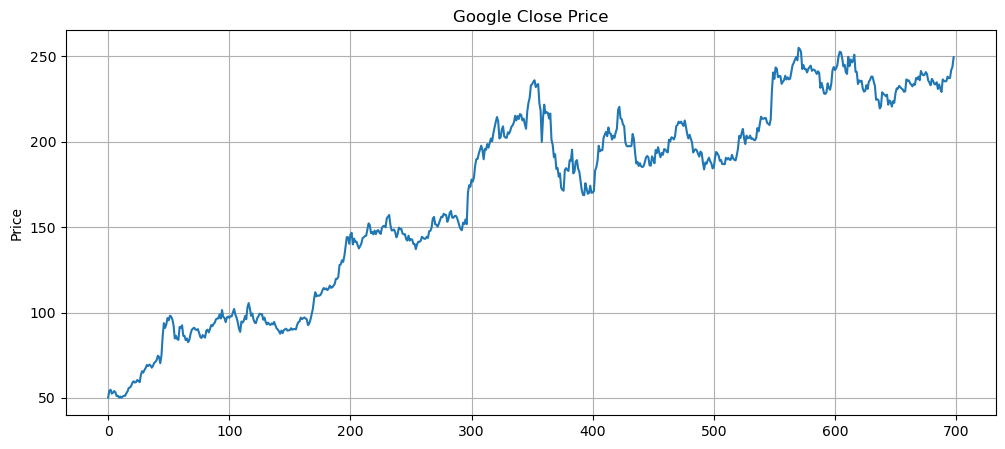

In [68]:
#Exploratory data analysis
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title('Google Close Price')
plt.ylabel('Price')
plt.grid('on')
plt.show()

In [69]:
# Check for nulls
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [70]:
attributes = ['Open', 'High', 'Low', 'Close', 'Volume']

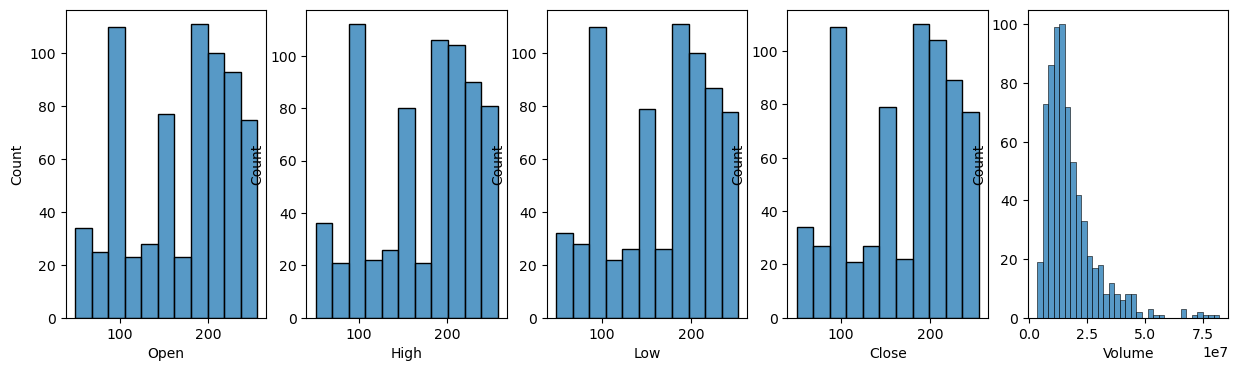

In [71]:
plt.figure(figsize=(15,4))
for i, attribute in enumerate(attributes):
    plt.subplot(1,5,i+1)
    sns.histplot(x=df[attribute])
plt.show()

# You notice one main peak around $30 which shows the price region where the price has varied the most
# Volume data is skewed left

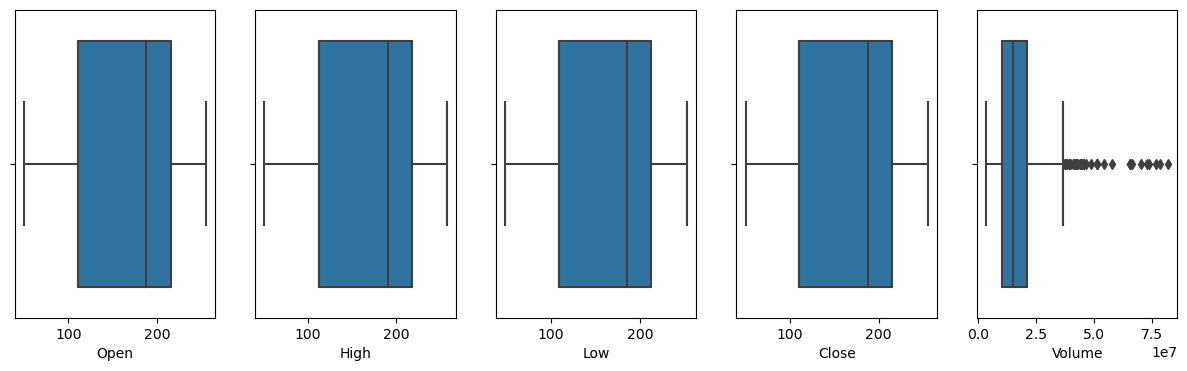

In [72]:
plt.figure(figsize=(15,4))
for i, attribute in enumerate(attributes):
    plt.subplot(1,5,i+1)
    sns.boxplot(x=df[attribute])
plt.show()

In [73]:

splitted = df['Date'].str.split('-', expand=True)
 
df['day'] = splitted[2].astype('int')
df['month'] = splitted[1].astype('int')
df['year'] = splitted[0].astype('int')
 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day,month,year
0,19-08-2004,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,2004,8,19
1,20-08-2004,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,2004,8,20
2,23-08-2004,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,2004,8,23
3,24-08-2004,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,2004,8,24
4,25-08-2004,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,2004,8,25


<Figure size 2500x1000 with 0 Axes>

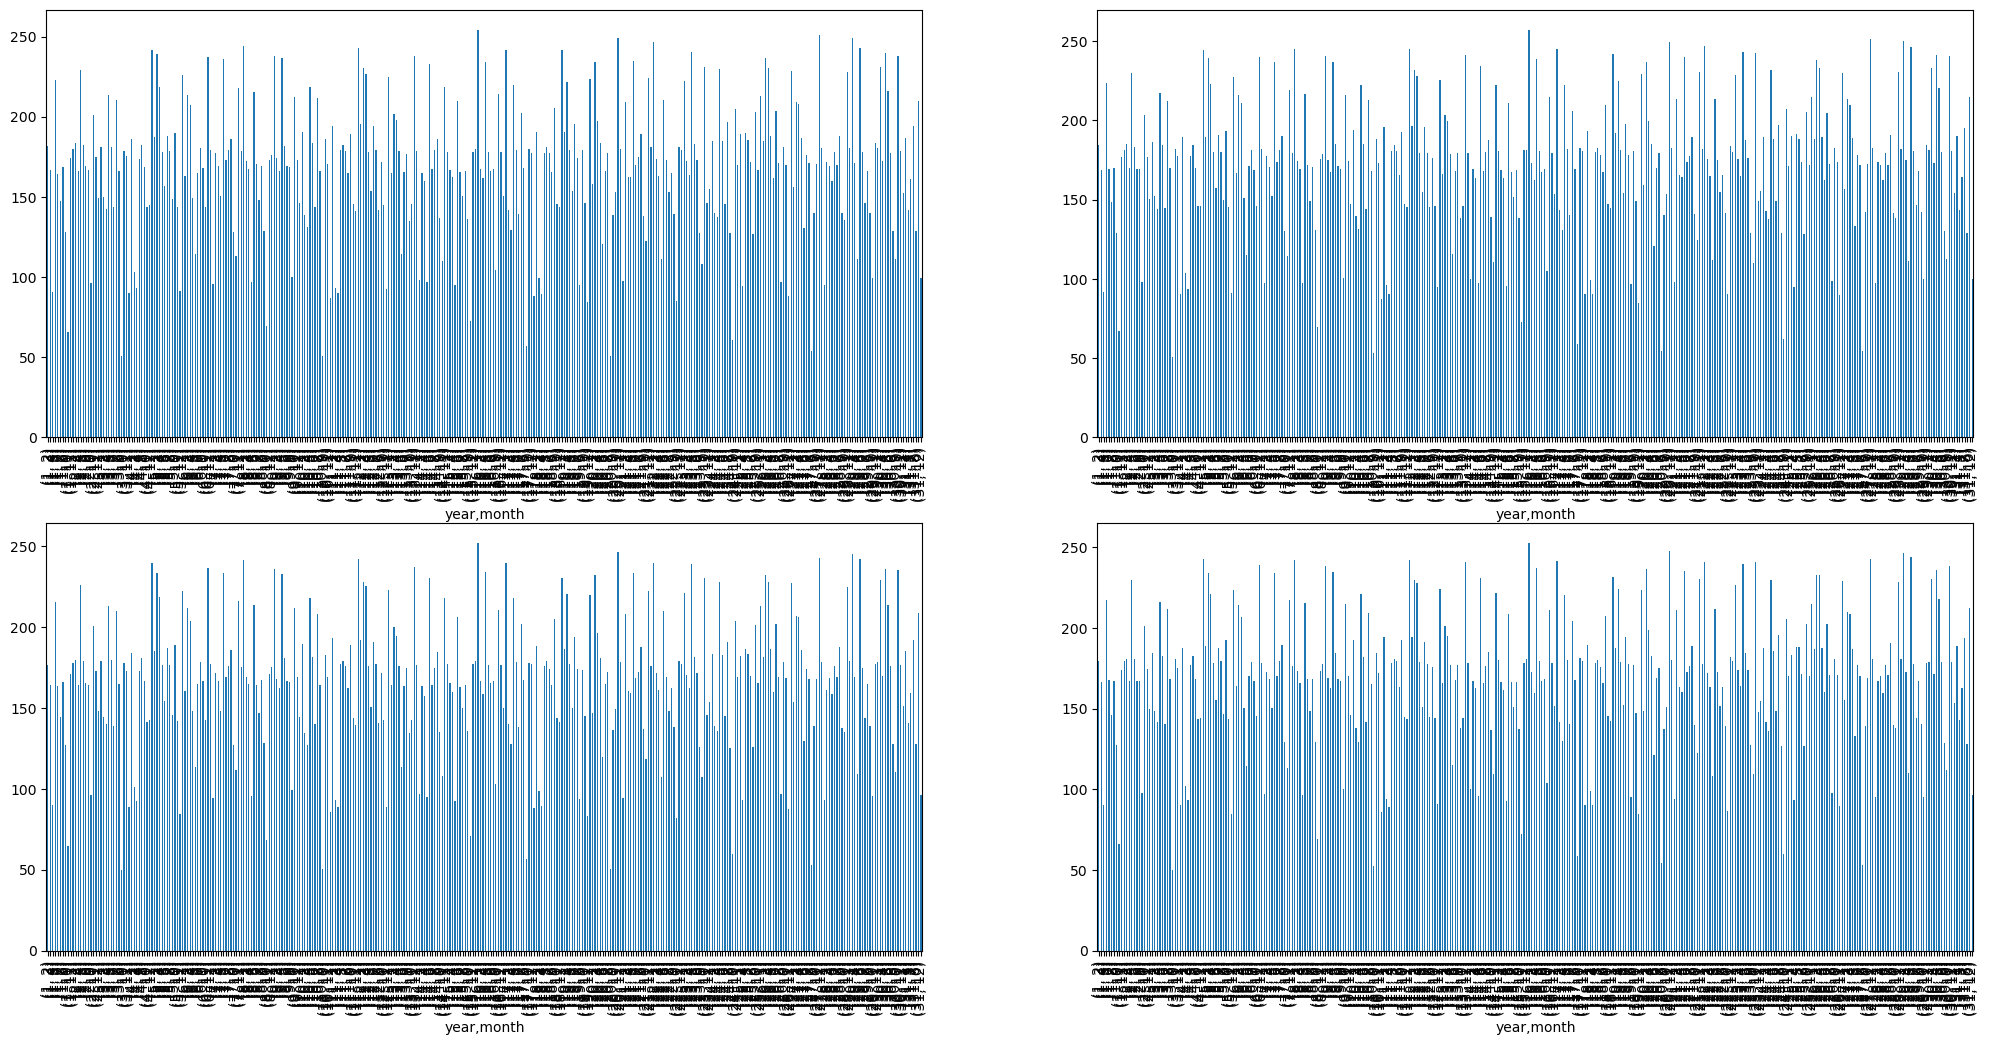

In [74]:
# average price each month of each year
plt.figure(figsize=(25,10))
data_grouped = df.groupby(['year', 'month']).mean()
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    data_grouped[col].plot.bar()
   
plt.show()

In [75]:
# Calculating SMA
def get_sma(prices, rate):
    return prices.rolling(rate).mean()
    
closing_prices = df['Close']

sma = get_sma(closing_prices, 20) # 20 day SMA

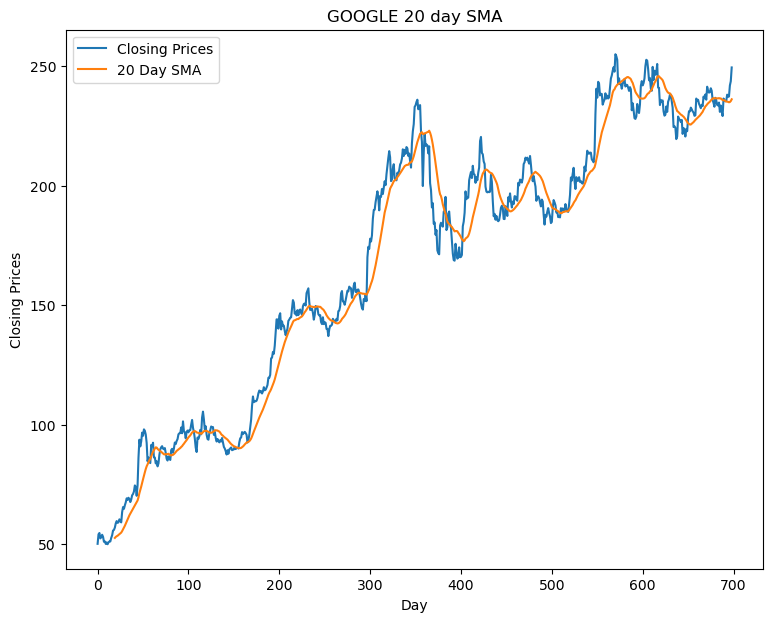

In [76]:
plt.figure(figsize=(9,7))
plt.title('GOOGLE 20 day SMA')
plt.xlabel('Day')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(sma, label='20 Day SMA')
plt.legend()
plt.show()

In [77]:
def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2
    bollinger_down = sma - std * 2
    return bollinger_up, bollinger_down

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

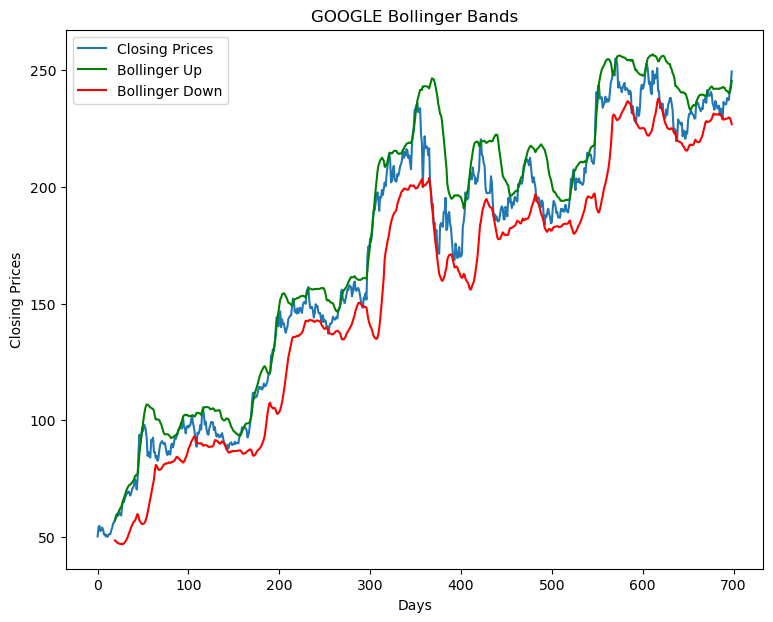

In [78]:
plt.figure(figsize=(9,7))
plt.title('GOOGLE Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()

In [79]:
def signal(sma, up, down):
    if sma > up:
        return 'buy'
    elif sma < down:
        return 'sell'
    else:
        return 'hold'
    
sma_list = sma.tolist()
up_list = bollinger_up.tolist()
down_list = bollinger_down.tolist()

signals = []

for i in range(len(sma_list)):
    signals.append(signal(sma[i], up_list[i], down_list[i]))

number_buys = signals.count('buy')
number_sells = signals.count('sell')
print(number_buys, number_sells)

#There were no days where the SMA crossed a bollinger band

0 0


In [80]:
# Setting up data to train Neural Network with
df_close = df['Close'].values
df_close = df_close.reshape(-1,1)
num_values = df_close.shape[0]

training_data = np.array(df_close[:int(df_close.shape[0]*0.8)])
testing_data = np.array(df_close[int(df.shape[0]*0.8):])

data_scaler = MinMaxScaler(feature_range=(0,1))
trainer = data_scaler.fit_transform(training_data)
tester = data_scaler.fit_transform(testing_data)

# Function for creating our training and testing data set
# Puts the last 50 prices in X and the next price in Y
def generate_data(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

# Creating the training and testing data
x_train, y_train = generate_data(trainer)
x_test, y_test = generate_data(tester)

# Building recurrent neural network: 
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))


# Reshaping x data so it can be used by a neural net
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

# Compile mile using MSE because problem is regression 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Fitting the model to our data
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

3/3 [==============================] - 0s 64ms/step


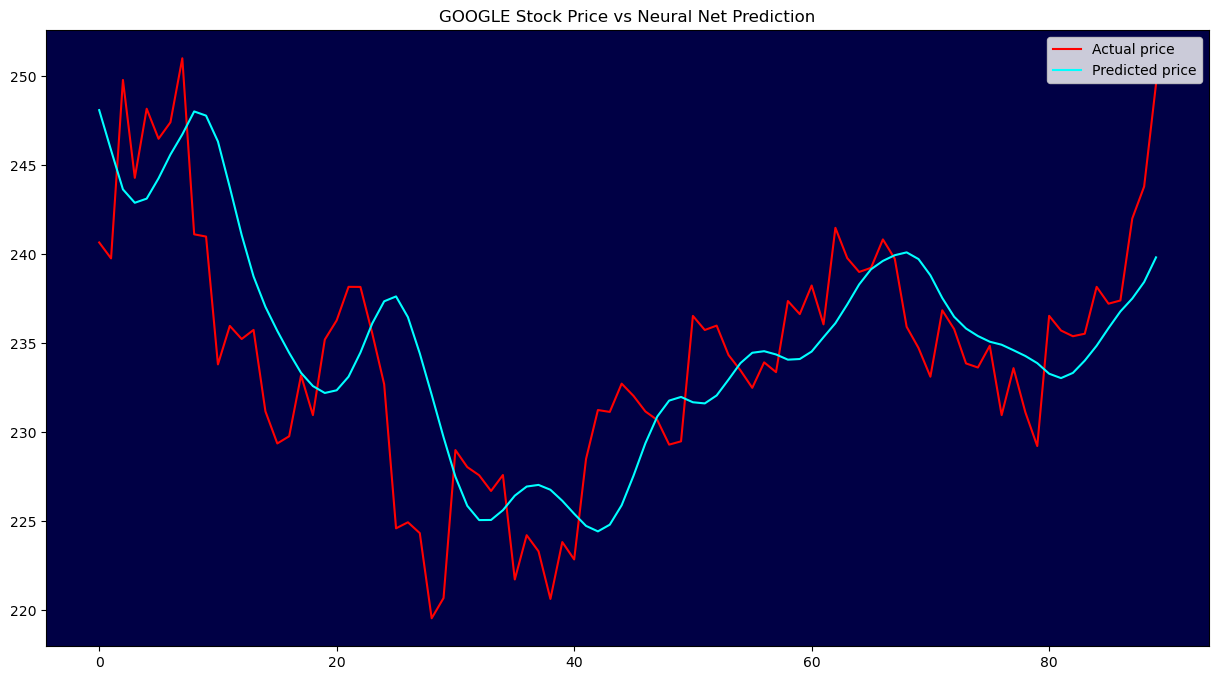

In [84]:
predict = model.predict(x_test)
# Scaling data back to original representation (dollars)
predict = data_scaler.inverse_transform(predict)
y_test_scaled = data_scaler.inverse_transform(y_test.reshape(-1,1))

# Plotting model results alongside actual price data
fig, ax = plt.subplots(figsize=(15,8))
ax.set_facecolor('#000045')
ax.plot(y_test_scaled, color='red', label='Actual price')
ax.plot(predict, color='cyan', label='Predicted price')
plt.title('GOOGLE Stock Price vs Neural Net Prediction')
plt.legend()

In [82]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [83]:
rmse = sqrt(mean_squared_error(y_test_scaled,predict))
print(f"Root mean squared error (RMSE) : {rmse:.2f}")

Root mean squared error (RMSE) : 4.84
